## Temporal Shifts
**When and how do presidents draw “us vs them” boundaries, how positive or negative is that framing, and which identity themes do they use to describe “us” versus “them” over time?**
 Approach:
  1. Regex counts of “us” vs “them/othering” language 
  2. Vader Sentiment of “we” vs “they/others” sentences 
  3. LLM-coded identity adjectives and themes 

### REGEX
**Count** of "us/American" vs "them/other" mentions in presidental speeches

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import display

CSV_PATH   = "../data/all_speeches.csv"   
ROLL_YEARS = 5

DISPLAY_MAP = {
    "US_per_1k": "US (we/us/our)/1k",
    "they_per_1k": "They/1k",
    "others_per_1k": "Othering terms/1k",
    "amer_per_1k": "American mentions/1k",
    "inc_exc_ratio": "Incl : Excl",
}

def as_display(df, cols, index_name=None, round_to=3):
    cols = [c for c in cols if c in df.columns]
    out = df[cols].rename(
        columns={k: DISPLAY_MAP.get(k, k) for k in cols}
    ).round(round_to)
    return out.rename_axis(index_name) if index_name else out

#  regex patterns 

# us pronouns
US_RE   = re.compile(r"\b(we|us|our|ours|ourselves)\b", re.I)

# they pronouns
THEY_RE  = re.compile(r"\b(they|them|their|theirs|themselves)\b", re.I)

# explicit "others"
OTHER_RE = re.compile(
    r"\b(immigrant|immigrants|refugee|refugees|foreigner|foreigners|"
    r"terrorist|terrorists|communist|communists|muslim|muslims|"
    r"mexican|mexicans|chinese|russian|japanese|german|british|"
    r"enemy|enemies|outsider|aliens|other|others,indians, indian,extermists)\b",
    re.I,
)
# American mentions
AMER_RE = re.compile(
    r"\b(American|Americans|American people)\b",
    re.I,
)



In [ ]:
# Load the speeches
speeches = pd.read_csv(CSV_PATH)

#  Resolve key columns 
TEXT_COL = (
    "transcript"
    if "transcript" in speeches.columns
    else next(
        c for c in speeches.columns
        if c.lower() in {"text", "speech_text", "body"}
    )
)

DATE_COL = (
    "date"
    if "date" in speeches.columns
    else next(
        c for c in speeches.columns
        if "date" in c.lower()
    )
)

PRES_COL = (
    "president"
    if "president" in speeches.columns
    else next(
        (c for c in speeches.columns if c.lower() in {"speaker", "author"}),
        None
    )
)

# Parse date + year 
# keep only YYYY-MM-DD if there's extra time info
speeches[DATE_COL] = speeches[DATE_COL].astype(str).str[:10]
speeches["date"] = pd.to_datetime(speeches[DATE_COL], errors="coerce")
speeches["year"] = speeches["date"].dt.year

# Clean text + word counts (for per-1k normalization)
speeches["text_clean"] = speeches[TEXT_COL].fillna("")
speeches["word_count"] = (
    speeches["text_clean"]
    .str.split()
    .str.len()
    .clip(lower=1)   # avoid divide-by-zero later
)

# check
display(speeches[[PRES_COL, "title", "year", "word_count"]].head())
print("Using text column:", TEXT_COL)
print("Using date column:", DATE_COL)


,president,title,year,word_count
0,Thomas Jefferson,"July 2, 1807: Proclamation in Response to the ...",1807,1170
1,William McKinley,"December 3, 1900: Fourth Annual Message",1900,19141
2,Thomas Jefferson,"December 2, 1806: Sixth Annual Message",1806,2876
3,Martin Van Buren,"January 5, 1838: Proclamation",1838,395
4,Grover Cleveland,"December 17, 1895: Message Regarding Venezuela...",1895,1577


Using text column: transcript
Using date column: date


In [ ]:
# regex counts using text_clean 

# we/us/our
speeches["us_ct"]    = speeches["text_clean"].str.count(US_RE)

# they/them/their
speeches["they_ct"]   = speeches["text_clean"].str.count(THEY_RE)

# explicit othering terms
speeches["others_ct"] = speeches["text_clean"].str.count(OTHER_RE)

# explicit American mentions 
speeches["amer_ct"]   = speeches["text_clean"].str.count(AMER_RE)

# normalize to per-1k words 
speeches["us_per_1k"]    = 1000 * speeches["us_ct"]    / speeches["word_count"]
speeches["they_per_1k"]   = 1000 * speeches["they_ct"]   / speeches["word_count"]
speeches["others_per_1k"] = 1000 * speeches["others_ct"] / speeches["word_count"]
speeches["amer_per_1k"]   = 1000 * speeches["amer_ct"]   / speeches["word_count"]

# convenience columns
speeches["exc_per_1k"]    = speeches["they_per_1k"] + speeches["others_per_1k"]
speeches["inc_per_1k"]    = speeches["us_per_1k"] + speeches["amer_per_1k"]
speeches["inc_exc_ratio"] = (speeches["us_ct"] +speeches["amer_ct"]+ 1) / (speeches["they_ct"] + speeches["others_ct"] + 1)


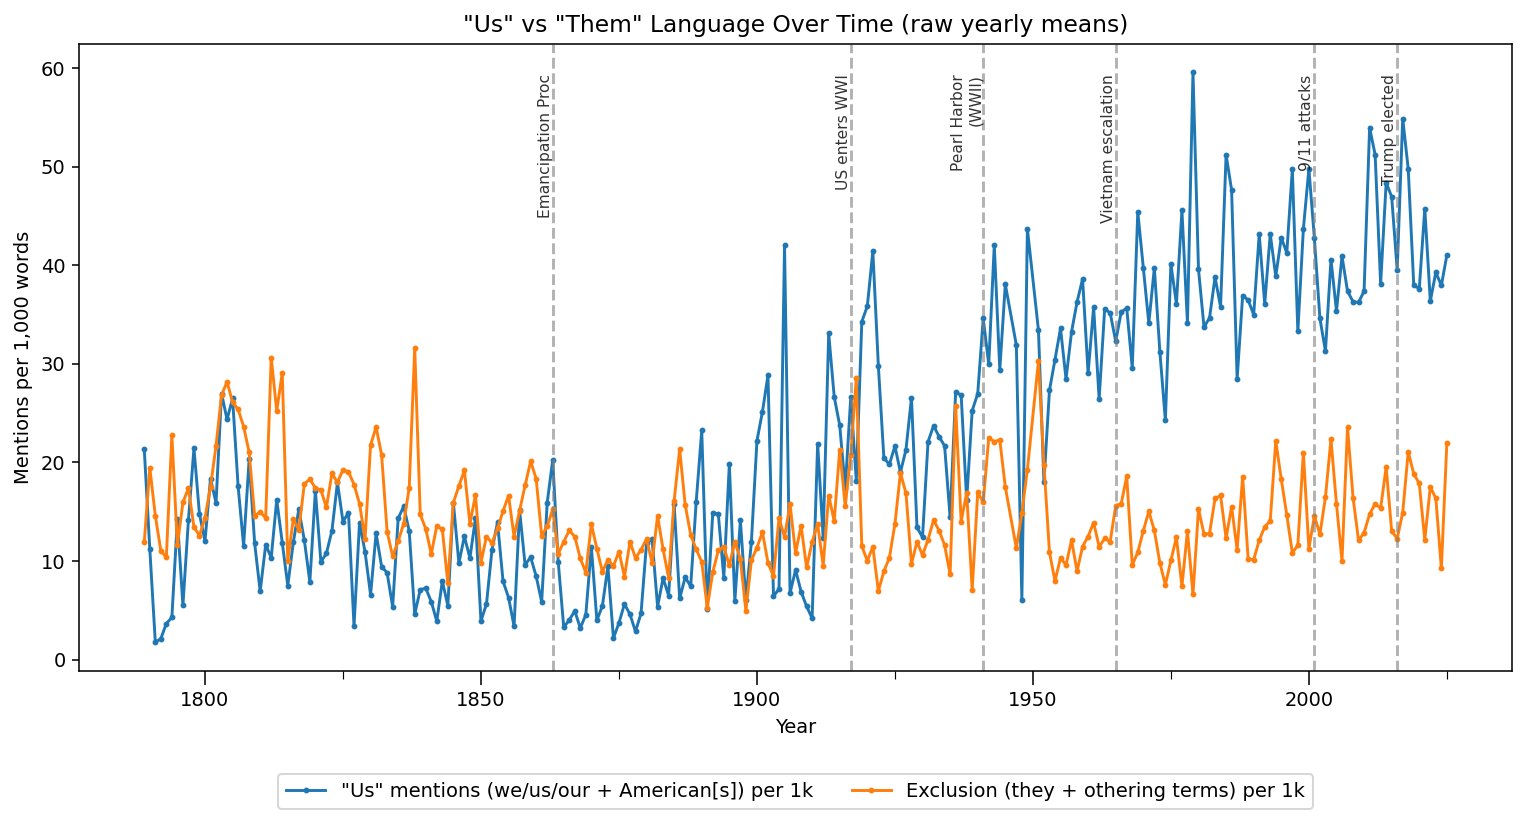

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# raw yearly means 
yearly = (
    speeches
    .groupby("year")[["inc_per_1k", "exc_per_1k"]]
    .mean()
    .sort_index()
)

# exclusion = they + othering (already in exc_per_1k)
exc_raw = yearly["exc_per_1k"]
net_raw = yearly["inc_per_1k"] - exc_raw   # net inclusion

# "Us-talk" vs Exclusion (raw yearly)
fig, ax = plt.subplots(figsize=(11, 6), dpi=140)

ax.plot(
    yearly.index,
    yearly["inc_per_1k"],
    label='"Us" mentions (we/us/our + American[s]) per 1k',
    marker="o",
    ms=2,
)

ax.plot(
    yearly.index,
    exc_raw,
    label='Exclusion (they + othering terms) per 1k',
    marker="o",
    ms=2,
)
# Add key historical events
events = {
    1863: "Emancipation Proc",
    1917: "US enters WWI",
    1941: "Pearl Harbor\n(WWII)",
    1965: "Vietnam escalation",
    2001: "9/11 attacks",
    2016: "Trump elected",
}

ymin, ymax = plt.ylim()

for x, label in events.items():
    plt.axvline(x=x, color="gray", linestyle="--", alpha=0.6)
    plt.text(
        x,
        ymax * 0.95,
        label,
        rotation=90,
        va="top",
        ha="right",
        fontsize=8,
        alpha=0.8,
    )

ax.set_xlabel("Year")
ax.set_ylabel("Mentions per 1,000 words")
ax.set_title('"Us" vs "Them" Language Over Time (raw yearly means)')
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.tick_params(axis="x", which="minor", length=4)
ax.tick_params(axis="x", which="major", length=7)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
)
plt.tight_layout()
plt.show()




### VADER
Santiment analysis of the Regex pattens to see **tone** of "us/American" vs "them/other" mentions

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

analyzer = SentimentIntensityAnalyzer()

# check 
print("Columns in speeches:", speeches.columns)


Columns in speeches: Index(['Unnamed: 0', 'title', 'doc_name', 'url', 'date', 'transcript',
       'transcript_html', 'president', 'introduction', 'video', 'audio',
       'year', 'text_clean', 'word_count', 'us_ct', 'they_ct', 'others_ct',
       'amer_ct', 'us_per_1k', 'they_per_1k', 'others_per_1k', 'amer_per_1k',
       'exc_per_1k', 'inc_per_1k', 'inc_exc_ratio'],
      dtype='object')


In [ ]:
import re
import pandas as pd

sent_rows = []

# choose an ID for speeches 
SPEECH_ID_COL = "doc_name" if "doc_name" in speeches.columns else "title"
TEXT_COL = "text_clean"   # take from regex setup

for row in speeches.itertuples():
    year = row.year
    if pd.isna(year):
        continue

    speech_id = getattr(row, SPEECH_ID_COL)
    text = str(getattr(row, TEXT_COL, ""))

    # simple sentence split
    sentences = re.split(r'(?<=[.!?])\s+', text)
    for s in sentences:
        s_strip = s.strip()
        if not s_strip:
            continue

        # USE THE SAME REGEX CATEGORIES AS  COUNTS
        has_us   = bool(US_RE.search(s_strip))  # we/us/our + American(s)
        has_them = bool(THEY_RE.search(s_strip) or OTHER_RE.search(s_strip))

        # skip sentences with no us/them
        if not (has_us or has_them):
            continue

        if has_us and not has_them:
            sent_type = "us_only"
        elif has_them and not has_us:
            sent_type = "them_only"
        else:
            sent_type = "both"  # mixed us and them

        vs = analyzer.polarity_scores(s_strip)

        sent_rows.append({
            "year": int(year),
            "speech_id": speech_id,
            "sentence": s_strip,
            "type": sent_type,
            "compound": vs["compound"],
        })

sent_df = pd.DataFrame(sent_rows)
print("Sentence-level rows:", len(sent_df))
display(sent_df.head())
print(sent_df["type"].value_counts())


Sentence-level rows: 74665


,year,speech_id,sentence,type,compound
0,1807,/the-presidency/presidential-speeches/july-2-1...,During the wars which for some time have unhap...,them_only,0.8658
1,1807,/the-presidency/presidential-speeches/july-2-1...,Taking no part in the questions which animate ...,them_only,0.9081
2,1807,/the-presidency/presidential-speeches/july-2-1...,"A free use of their harbors and waters, the me...",both,-0.5267
3,1807,/the-presidency/presidential-speeches/july-2-1...,"In truth, these abuses of the laws of hospital...",both,-0.3182
4,1807,/the-presidency/presidential-speeches/july-2-1...,They have been the subject of repeated represe...,them_only,0.0000


type
us_only      36889
them_only    23339
both         14437
Name: count, dtype: int64


In [ ]:
# keep only clean years
sent_df_clean = sent_df[sent_df["year"].notna()].copy()
sent_df_clean["year"] = sent_df_clean["year"].astype(int)

# focus on clearly us-only vs them-only
sent_df_sub = sent_df_clean[sent_df_clean["type"].isin(["us_only", "them_only"])].copy()

# average sentiment WITHIN each speech for us & them
speech_sent = (
    sent_df_sub
    .groupby(["year", "speech_id", "type"])["compound"]
    .mean()               # avg across sentences of that type in that speech
    .unstack("type")      # columns: us_only, them_only
    .reset_index()
)

print("Speech-level sentiment (one row per speech):")
display(speech_sent.head())

# average ACROSS speeches per year (each speech counts once)
year_sent_norm = (
    speech_sent
    .groupby("year")[["us_only", "them_only"]]
    .mean()
    .reset_index()
    .sort_values("year")
)

print("Year-level normalized sentiment:")
display(year_sent_norm.head())


Speech-level sentiment (one row per speech):


type,year,speech_id,them_only,us_only
0,1789,/the-presidency/presidential-speeches/april-30...,0.413425,0.982600
1,1789,/the-presidency/presidential-speeches/october-...,0.995100,NaN
2,1790,/the-presidency/presidential-speeches/december...,0.153813,NaN
3,1790,/the-presidency/presidential-speeches/december...,0.331512,0.370160
4,1790,/the-presidency/presidential-speeches/january-...,0.731475,0.401867


Year-level normalized sentiment:


type,year,us_only,them_only
0,1789,0.982600,0.704263
1,1790,0.386013,0.405600
2,1791,0.916350,0.523230
3,1792,-0.117700,0.623947
4,1793,0.374025,0.184810


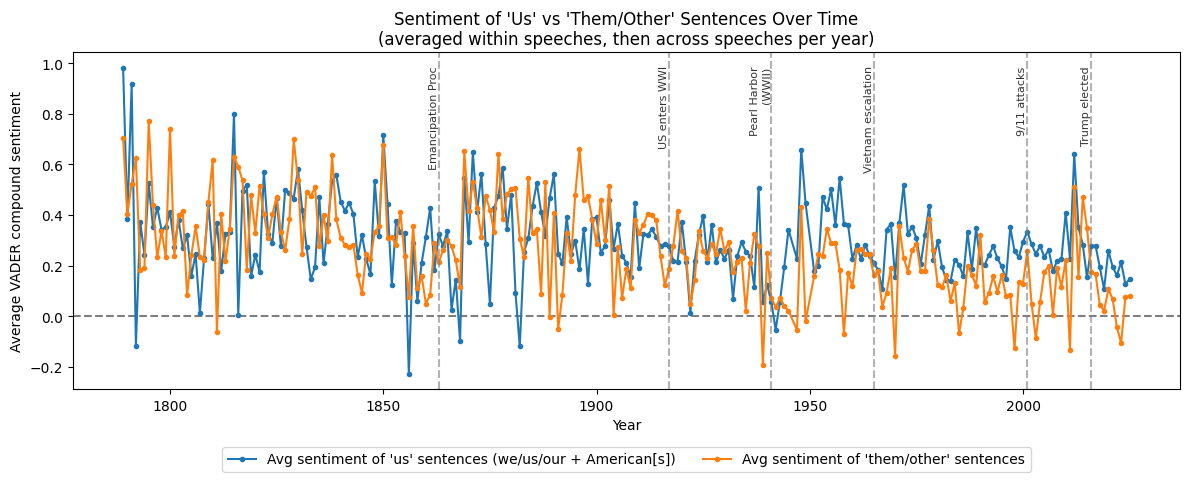

In [109]:
plt.figure(figsize=(12, 5))

# zero line
plt.axhline(0, color="k", linestyle="--", alpha=0.5)

if "us_only" in year_sent_norm.columns:
    plt.plot(
        year_sent_norm["year"],
        year_sent_norm["us_only"],
        marker=".",
        label="Avg sentiment of 'us' sentences (we/us/our + American[s])",
    )

if "them_only" in year_sent_norm.columns:
    plt.plot(
        year_sent_norm["year"],
        year_sent_norm["them_only"],
        marker=".",
        label="Avg sentiment of 'them/other' sentences",
    )

# Add key historical events
events = {
    1863: "Emancipation Proc",
    1917: "US enters WWI",
    1941: "Pearl Harbor\n(WWII)",
    1965: "Vietnam escalation",
    2001: "9/11 attacks",
    2016: "Trump elected",
}

ymin, ymax = plt.ylim()

for x, label in events.items():
    plt.axvline(x=x, color="gray", linestyle="--", alpha=0.6)
    plt.text(
        x,
        ymax * 0.95,
        label,
        rotation=90,
        va="top",
        ha="right",
        fontsize=8,
        alpha=0.8,
    )

plt.xlabel("Year")
plt.ylabel("Average VADER compound sentiment")
plt.title(
    "Sentiment of 'Us' vs 'Them/Other' Sentences Over Time\n"
    "(averaged within speeches, then across speeches per year)"
)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
)

plt.tight_layout()
plt.show()


#### Validation for VADER scorees
Export a random sample of 50 us_only and them_only sentences. Manually check csv to see if VADER scores match manual scores. 

In [ ]:
# Focus on us-only and them-only sentences
df_val = sent_df[sent_df["type"].isin(["us_only", "them_only"])].copy()

# random Sample of 50 us sentences and 50 them sentences
us_sample   = df_val[df_val["type"] == "us_only"].sample(50, random_state=0)
them_sample = df_val[df_val["type"] == "them_only"].sample(50, random_state=1)

val_sample = pd.concat([us_sample, them_sample]).sample(frac=1, random_state=2).reset_index(drop=True)
display(val_sample[["year", "type", "sentence", "compound"]].head())


,year,type,sentence,compound
0,1996,them_only,"They share the same piece of land, but they ar...",0.1531
1,1980,us_only,In the 1940s we took the lead in creating the ...,-0.3182
2,1962,them_only,"In that same spirit, and in the historic tradi...",0.8670
3,1993,us_only,We have to do what really works to increase le...,0.5046
4,1983,us_only,One of out of every five jobs in our country d...,0.0000


In [ ]:
#take into a csv to look at manually
val_sample.to_csv("../data/vader_validation_sample.csv", index=False)

In [ ]:
# ALSO LOOK AT MOST AND LEAST 
# Most negative "them" sentences
neg_them = (
    sent_df[(sent_df["type"] == "them_only")]
    .nsmallest(10, "compound")[["year", "sentence", "compound"]]
)
display(neg_them)

# Most positive "us" sentences
pos_us = (
    sent_df[(sent_df["type"] == "us_only")]
    .nlargest(10, "compound")[["year", "sentence", "compound"]]
)
display(pos_us)



,year,sentence,compound
49957,1814,Whereas the enemy by a sudden incursion have s...,-0.9929
57097,1858,Slavery can therefore never be prohibited in K...,-0.9928
7080,1875,To the Senate of the United States:<br />\r\nI...,-0.9916
38909,2013,"The situation profoundly changed, though, on A...",-0.9908
44420,1905,"Of these abuses, perhaps the chief, although b...",-0.9884
68916,1985,"The awful evil started by one man, an evil tha...",-0.9883
19112,1813,"They have not, it is true, taken into their ow...",-0.9867
72897,1906,The punishment meet for mutineers and murderer...,-0.9850
30861,1856,Those designs and acts had the necessary conse...,-0.9847
29232,1906,Every colored man should realize that the wors...,-0.9844


,year,sentence,compound
40217,2009,"Born in the South Bronx, she was raised in a h...",0.9988
31091,1877,"Human judgment is never unerring, and is rarel...",0.9967
50320,1970,We have such a cause.<br />\r\n<br />\r\nHow w...,0.9966
29178,2013,I’ve borne witness to the ancient history of t...,0.9960
18376,2012,I’m not talking about blind optimism -- the ki...,0.9958
20501,1889,When the centennial of the institutionof the j...,0.9952
29196,2013,And as the President of a country that you can...,0.9944
57246,1965,We will increase research to learn much more a...,0.9941
31675,1953,"Nevertheless, I assure you that in our deliber...",0.9937
33397,1974,I shall continue to work for the great causes ...,0.9937


### LLM adjective themes: in-group vs out-group (20% sample)

Look at themes of in-group and out-group themes over decades

,Unnamed: 0,title,transcript,transcript_cleaned,president,date,year,in_group_adjectives,out_group_adjectives
0,440,"April 2, 1917: Address to Congress Requesting ...",I have called the Congress into extraordinary ...,called congress extraordinary session serious ...,Woodrow Wilson,1917-04-02 18:00:00+00:00,1917,"['democratic', 'principled', 'humanitarian', '...","['autocratic', 'lawless', 'ruthless', 'decepti..."
1,514,"June 28, 1934: Fireside Chat 5: On Addressing ...",It has been several months since I have talked...,several months since talked concerning problem...,Franklin D. Roosevelt,1934-06-28 17:00:00+00:00,1934,"['democratic', 'just', 'progressive', 'secure'...","['selfish', 'greedy', 'unfair', 'corrupt', 'ti..."
2,565,"June 20, 1947: On the Veto of the Taft-Hartley...",My fellow countrymen:<br />\r\nAt noon today I...,fellow countrymen noon today sent congress mes...,Harry S. Truman,1947-06-20 19:00:00+00:00,1947,"['fair', 'just', 'democratic', 'free', 'cooper...","['unfair', 'divisive', 'restrictive', 'abusive..."
3,186,"March 4, 1853: Inaugural Address",My Countrymen:&nbsp; It a relief to feel that ...,countrymen nbsp relief feel heart know persona...,Franklin Pierce,1853-03-04 17:59:58+00:00,1853,"['united', 'free', 'principled', 'strong', 'du...","['sectional', 'tyrannical', 'dishonorable', 'w..."
4,515,"September 30, 1934: Fireside Chat 6: On Govern...",Three months have passed since I talked with y...,three months passed since talked shortly adjou...,Franklin D. Roosevelt,1934-09-30 18:00:00+00:00,1934,"['orderly', 'just', 'progressive', 'pragmatic'...","['chaotic', 'unjust', 'unscrupulous', 'obstruc..."


Columns: Index(['Unnamed: 0', 'title', 'transcript', 'transcript_cleaned', 'president',
       'date', 'year', 'in_group_adjectives', 'out_group_adjectives'],
      dtype='object')


,year,n_speeches
0,1790,1
1,1791,1
2,1794,2
3,1795,1
4,1796,1
5,1797,1
6,1798,1
7,1801,1
8,1805,2
9,1806,1


Total speeches in 20% sample: 207
Unique years: 133


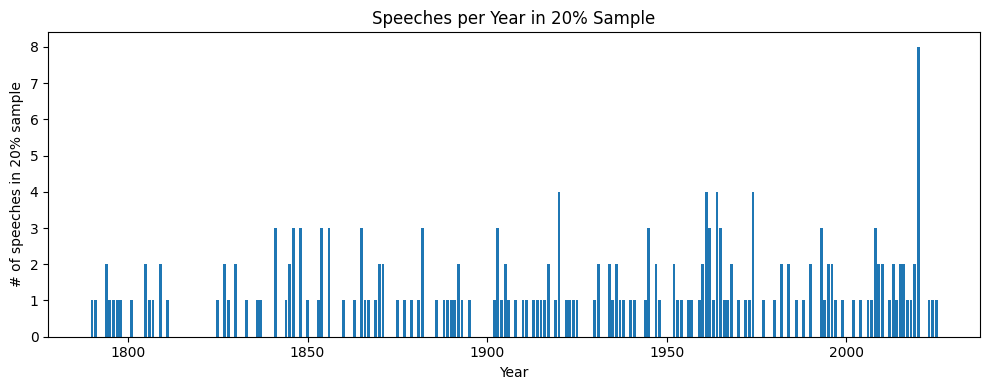

In [ ]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "../data/_20_percent_sample.csv"

# Load 20% sample csv
df = pd.read_csv(CSV_PATH)
display(df.head())
print("Columns:", df.columns)

# Ensure year column exists 
if "year" not in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year

# look at how many speeches per year 
speeches_per_year = (
    df.groupby("year")["title"]  # any non-null column works
      .size()
      .reset_index(name="n_speeches")
      .sort_values("year")
)

display(speeches_per_year.head(20))
print("Total speeches in 20% sample:", len(df))
print("Unique years:", speeches_per_year["year"].nunique())

# visualization
plt.figure(figsize=(10, 4))
plt.bar(speeches_per_year["year"], speeches_per_year["n_speeches"])
plt.xlabel("Year")
plt.ylabel("# of speeches in 20% sample")
plt.title("Speeches per Year in 20% Sample")
plt.tight_layout()
plt.show()


In [ ]:
#  Load in-group / out-group theme key files csvs
in_key = pd.read_csv("../data/in_group_words_key.csv")
out_key = pd.read_csv("../data/out_group_words_key.csv")

display(in_key.head())
display(out_key.head())

def safe_list_eval(x):
    """Safely parse a stringified Python list; return [] on failure."""
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return []

# Convert theme word lists from strings into Python lists
in_key["word_list"] = in_key["words"].apply(safe_list_eval)
out_key["word_list"] = out_key["words"].apply(safe_list_eval)

# Build lookup dicts: word to adj_theme 
in_lookup = {}
for _, row in in_key.iterrows():
    theme = row["adj_theme"]
    for w in row["word_list"]:
        in_lookup[w.lower()] = theme

out_lookup = {}
for _, row in out_key.iterrows():
    theme = row["adj_theme"]
    for w in row["word_list"]:
        out_lookup[w.lower()] = theme

print("Example in-group mappings (first 10):")
print(list(in_lookup.items())[:10])

print("\nExample out-group mappings (first 10):")
print(list(out_lookup.items())[:10])


,Unnamed: 0,adj_theme,words
0,0,Principled,"['accountable', 'ethical', 'moral', 'incorrupt..."
1,1,Capable,"['rational', 'reasonable', 'knowledgeable', 'a..."
2,2,Collaborative,"['common', 'global-minded', 'interdependent', ..."
3,3,Compassionate,"['compassionate', 'empathetic', 'humane', 'uns..."
4,4,Resilient,"['firm', 'strong', 'tough', 'persistent', 'rel..."


,Unnamed: 0,adj_theme,words
0,0,Oppressive,"['tyrannical', 'oppressive', 'authoritarian', ..."
1,1,Corrupt,"['corrupt', 'dishonest', 'fraudulent', 'decept..."
2,2,Violent,"['violent', 'aggressive', 'warlike', 'brutal',..."
3,3,Ineffective,"['weak', 'incompetent', 'inadequate', 'ineffec..."
4,4,Divisive,"['divisive', 'disunited', 'factious', 'conflic..."


Example in-group mappings (first 10):
[('accountable', 'Principled'), ('ethical', 'Principled'), ('moral', 'Principled'), ('incorruptible', 'Principled'), ('righteous', 'Principled'), ('principled', 'Principled'), ('honest', 'Principled'), ('just', 'Principled'), ('fair', 'Principled'), ('honorable', 'Principled')]

Example out-group mappings (first 10):
[('tyrannical', 'Oppressive'), ('oppressive', 'Oppressive'), ('authoritarian', 'Oppressive'), ('despotic', 'Oppressive'), ('dictatorial', 'Oppressive'), ('totalitarian', 'Oppressive'), ('draconian', 'Oppressive'), ('repressive', 'Oppressive'), ('suppressive', 'Oppressive'), ('coercive', 'Oppressive')]


In [ ]:
# Parse adjective lists from the sample CSV 

df["in_group_list"]  = df["in_group_adjectives"].apply(safe_list_eval)
df["out_group_list"] = df["out_group_adjectives"].apply(safe_list_eval)

# Lowercase all adjectives to match lookup keys
df["in_group_list"] = df["in_group_list"].apply(lambda lst: [w.lower() for w in lst])
df["out_group_list"] = df["out_group_list"].apply(lambda lst: [w.lower() for w in lst])

# Collect theme names
in_themes  = sorted(in_key["adj_theme"].unique().tolist())
out_themes = sorted(out_key["adj_theme"].unique().tolist())

def count_themes(word_list, lookup, theme_names):
    """
    Count how many times words in `word_list` map into each theme via `lookup`.
    Returns a list aligned with theme_names.
    """
    counts = dict.fromkeys(theme_names, 0)
    for w in word_list:
        theme = lookup.get(w)
        if theme in counts:
            counts[theme] += 1
    return [counts[t] for t in theme_names]

# In-group theme counts per speech 
in_theme_counts = df["in_group_list"].apply(
    lambda lst: pd.Series(count_themes(lst, in_lookup, in_themes))
)
in_theme_counts.columns = [f"in_{c}" for c in in_themes]

# Out-group theme counts per speech 
out_theme_counts = df["out_group_list"].apply(
    lambda lst: pd.Series(count_themes(lst, out_lookup, out_themes))
)
out_theme_counts.columns = [f"out_{c}" for c in out_themes]

# Attach theme counts to the main DF
df_with_themes = pd.concat([df, in_theme_counts, out_theme_counts], axis=1)

display(df_with_themes.head())


,Unnamed: 0,title,transcript,transcript_cleaned,president,date,year,in_group_adjectives,out_group_adjectives,in_group_list,...,out_Extreme,out_Ideological,out_Immoral,out_Ineffective,out_Oppressive,out_Pessimistic,out_Reckless,out_Unjust,out_Violent,out_Vulnerable
0,440,"April 2, 1917: Address to Congress Requesting ...",I have called the Congress into extraordinary ...,called congress extraordinary session serious ...,Woodrow Wilson,1917-04-02 18:00:00+00:00,1917,"['democratic', 'principled', 'humanitarian', '...","['autocratic', 'lawless', 'ruthless', 'decepti...","[democratic, principled, humanitarian, peacefu...",...,0,0,1,0,0,0,0,0,0,0
1,514,"June 28, 1934: Fireside Chat 5: On Addressing ...",It has been several months since I have talked...,several months since talked concerning problem...,Franklin D. Roosevelt,1934-06-28 17:00:00+00:00,1934,"['democratic', 'just', 'progressive', 'secure'...","['selfish', 'greedy', 'unfair', 'corrupt', 'ti...","[democratic, just, progressive, secure, practi...",...,0,0,0,0,0,0,0,1,0,1
2,565,"June 20, 1947: On the Veto of the Taft-Hartley...",My fellow countrymen:<br />\r\nAt noon today I...,fellow countrymen noon today sent congress mes...,Harry S. Truman,1947-06-20 19:00:00+00:00,1947,"['fair', 'just', 'democratic', 'free', 'cooper...","['unfair', 'divisive', 'restrictive', 'abusive...","[fair, just, democratic, free, cooperative]",...,0,0,0,1,2,0,0,1,0,0
3,186,"March 4, 1853: Inaugural Address",My Countrymen:&nbsp; It a relief to feel that ...,countrymen nbsp relief feel heart know persona...,Franklin Pierce,1853-03-04 17:59:58+00:00,1853,"['united', 'free', 'principled', 'strong', 'du...","['sectional', 'tyrannical', 'dishonorable', 'w...","[united, free, principled, strong, dutiful]",...,0,0,0,1,1,0,0,0,0,0
4,515,"September 30, 1934: Fireside Chat 6: On Govern...",Three months have passed since I talked with y...,three months passed since talked shortly adjou...,Franklin D. Roosevelt,1934-09-30 18:00:00+00:00,1934,"['orderly', 'just', 'progressive', 'pragmatic'...","['chaotic', 'unjust', 'unscrupulous', 'obstruc...","[orderly, just, progressive, pragmatic, respon...",...,0,0,0,1,0,0,0,1,0,0


In [ ]:
# Normalize theme counts per 1,000 words 

# Choose transcript column
TEXT_COL = (
    "transcript_cleaned"
    if "transcript_cleaned" in df_with_themes.columns
    else "transcript"
)

# word count per speech
df_with_themes["n_words"] = (
    df_with_themes[TEXT_COL]
    .fillna("")
    .str.split()
    .str.len()
    .replace(0, np.nan)
)

# All theme count columns we just created
theme_count_cols = in_theme_counts.columns.tolist() + out_theme_counts.columns.tolist()

# Create per_1k columns
for col in theme_count_cols:
    df_with_themes[col + "_per_1k"] = (
        df_with_themes[col] / df_with_themes["n_words"] * 1000
    )

display(
    df_with_themes[
        ["title", "year"] + [c for c in df_with_themes.columns if c.endswith("_per_1k")][:6]
    ].head()
)


,title,year,in_Aspiring_per_1k,in_Autonomous_per_1k,in_Capable_per_1k,in_Collaborative_per_1k,in_Compassionate_per_1k,in_Confident_per_1k
0,"April 2, 1917: Address to Congress Requesting ...",1917,0.000000,0.547345,0.000000,0.547345,0.547345,0.0
1,"June 28, 1934: Fireside Chat 5: On Addressing ...",1934,0.768640,0.000000,0.768640,0.768640,0.000000,0.0
2,"June 20, 1947: On the Veto of the Taft-Hartley...",1947,0.000000,1.042753,0.000000,1.042753,0.000000,0.0
3,"March 4, 1853: Inaugural Address",1853,0.000000,0.592417,0.000000,0.592417,0.000000,0.0
4,"September 30, 1934: Fireside Chat 6: On Govern...",1934,0.601685,0.000000,0.601685,0.000000,0.000000,0.0


In [ ]:
# Prepare decade-level data 

df_t = df_with_themes.copy()
df_t = df_t[df_t["year"].notna()].copy()
df_t["year"] = df_t["year"].astype(int)
df_t["decade"] = (df_t["year"] // 10) * 10

# Per-1k theme columns
in_theme_cols_per_1k  = [c for c in df_t.columns if c.startswith("in_")  and c.endswith("_per_1k")]
out_theme_cols_per_1k = [c for c in df_t.columns if c.startswith("out_") and c.endswith("_per_1k")]

print("In-group per_1k theme columns:", in_theme_cols_per_1k)
print("Out-group per_1k theme columns:", out_theme_cols_per_1k)

# Sum all in-group / out-group themes per speech
df_t["total_in_themes_per_1k"]  = df_t[in_theme_cols_per_1k].sum(axis=1)
df_t["total_out_themes_per_1k"] = df_t[out_theme_cols_per_1k].sum(axis=1)

# Aggregate by decade
decade_summary = (
    df_t.groupby("decade")
        .agg(
            mean_in_per_1k=("total_in_themes_per_1k", "mean"),
            mean_out_per_1k=("total_out_themes_per_1k", "mean"),
            n_speeches=("title", "count"),
        )
        .reset_index()
        .sort_values("decade")
)

display(decade_summary.head())


In-group per_1k theme columns: ['in_Aspiring_per_1k', 'in_Autonomous_per_1k', 'in_Capable_per_1k', 'in_Collaborative_per_1k', 'in_Compassionate_per_1k', 'in_Confident_per_1k', 'in_Dedicated_per_1k', 'in_Dignified_per_1k', 'in_Peaceful_per_1k', 'in_Principled_per_1k', 'in_Resilient_per_1k']
Out-group per_1k theme columns: ['out_Corrupt_per_1k', 'out_Divisive_per_1k', 'out_Extreme_per_1k', 'out_Ideological_per_1k', 'out_Immoral_per_1k', 'out_Ineffective_per_1k', 'out_Oppressive_per_1k', 'out_Pessimistic_per_1k', 'out_Reckless_per_1k', 'out_Unjust_per_1k', 'out_Violent_per_1k', 'out_Vulnerable_per_1k']


,decade,mean_in_per_1k,mean_out_per_1k,n_speeches
0,1790,8.038840,6.444750,8
1,1800,10.508811,8.897060,7
2,1810,4.378284,4.378284,1
3,1820,4.994553,4.994553,4
4,1830,2.855250,0.845200,5


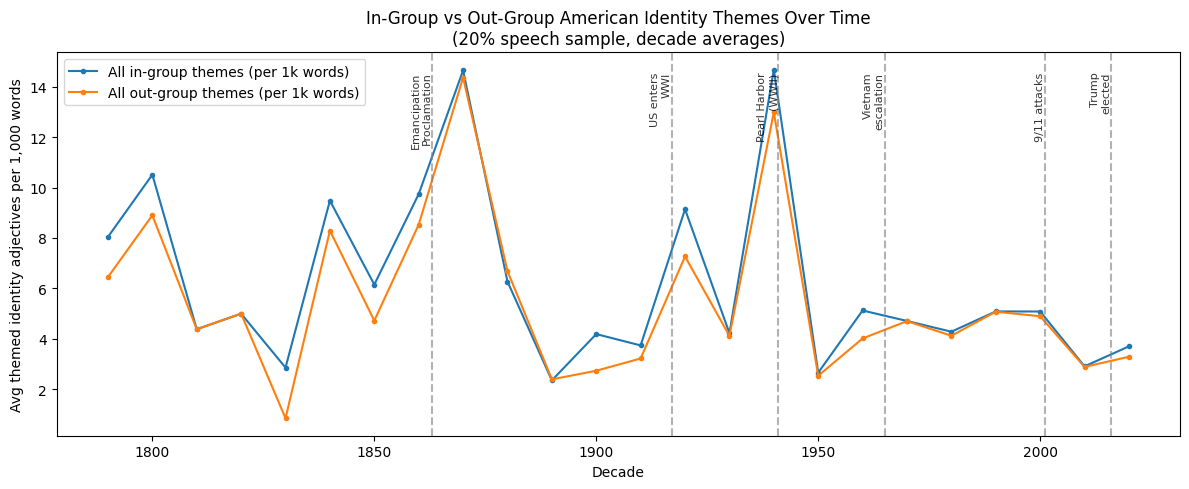

In [ ]:
# vizulization for over decade themes 
events = {
    1863: "Emancipation\nProclamation",
    1917: "US enters\nWWI",
    1941: "Pearl Harbor\n(WWII)",
    1965: "Vietnam\nescalation",
    2001: "9/11 attacks",
    2016: "Trump\nelected",
}

fig, ax = plt.subplots(figsize=(12, 5))

# main lines
ax.plot(
    decade_summary["decade"],
    decade_summary["mean_in_per_1k"],
    marker=".",
    label="All in-group themes (per 1k words)",
)
ax.plot(
    decade_summary["decade"],
    decade_summary["mean_out_per_1k"],
    marker=".",
    label="All out-group themes (per 1k words)",
)

# y-limits after plotting
ymin, ymax = ax.get_ylim()

# vertical event lines
for x, label in events.items():
    ax.axvline(x=x, color="gray", linestyle="--", alpha=0.6)
    ax.text(
        x,
        ymax * 0.95,
        label,
        rotation=90,
        va="top",
        ha="right",
        fontsize=8,
        alpha=0.8,
    )

ax.set_xlabel("Decade")
ax.set_ylabel("Avg themed identity adjectives per 1,000 words")
ax.set_title(
    "In-Group vs Out-Group American Identity Themes Over Time\n"
    "(20% speech sample, decade averages)"
)
ax.legend()
fig.tight_layout()
plt.show()


In [ ]:
#Themes for each decade
dec = 1920  #CHANGE DECADE HERE

# Get the row for that decade (one value per theme)
dec_row = decade_means.loc[dec]

# Build a small table with theme, mean, and within-decade std 
rows = []
decade_subset = df_t[df_t["decade"] == dec]  # all speeches in that decade

for col in all_theme_cols_per_1k:
    mean_val = dec_row[col]
    std_val  = decade_subset[col].std()  # variability of that theme within the decade
    rows.append({
        "theme": col.replace("_per_1k", ""),
        "mean_per_1k": mean_val,
        "std_within_decade": std_val,
    })

dec_df = pd.DataFrame(rows)

# Sort by mean descending to see which themes are strongest
dec_df_sorted = dec_df.sort_values("mean_per_1k", ascending=False)
dec_df_sorted.head(10)


,theme,mean_per_1k,std_within_decade
1,in_Autonomous,2.809094,2.875032
21,out_Violent,1.565426,2.642399
3,in_Collaborative,1.338977,1.849365
17,out_Oppressive,1.319212,2.529740
9,in_Principled,1.156497,2.319530
11,out_Corrupt,1.064275,1.531672
16,out_Ineffective,1.045061,2.493532
0,in_Aspiring,0.945860,1.668048
6,in_Dedicated,0.917130,1.605257
22,out_Vulnerable,0.856164,2.421599


In [88]:
# All per_1k theme columns
all_theme_cols_per_1k = in_theme_cols_per_1k + out_theme_cols_per_1k
print("Number of theme columns:", len(all_theme_cols_per_1k))

# Mean themed adjectives per decade for each theme
decade_means = df_t.groupby("decade")[all_theme_cols_per_1k].mean()

# How much each theme varies across decades (std over decades)
theme_variability = decade_means.std(axis=0).sort_values()

print("Most stable themes across decades (lowest std):")
display(theme_variability.head(10))

print("\nMost variable themes across decades (highest std):")
display(theme_variability.tail(10))


Number of theme columns: 23
Most stable themes across decades (lowest std):


out_Extreme_per_1k        0.057531
out_Pessimistic_per_1k    0.091244
out_Immoral_per_1k        0.144403
out_Reckless_per_1k       0.196060
in_Aspiring_per_1k        0.225084
out_Ideological_per_1k    0.227905
in_Confident_per_1k       0.256415
in_Dignified_per_1k       0.328313
out_Vulnerable_per_1k     0.396645
in_Peaceful_per_1k        0.433870
dtype: float64


Most variable themes across decades (highest std):


in_Resilient_per_1k        0.630076
in_Capable_per_1k          0.630337
in_Autonomous_per_1k       0.672477
in_Dedicated_per_1k        0.713722
out_Oppressive_per_1k      0.835964
in_Collaborative_per_1k    0.856184
out_Violent_per_1k         0.868359
out_Divisive_per_1k        0.869062
out_Corrupt_per_1k         0.976360
in_Principled_per_1k       1.453661
dtype: float64

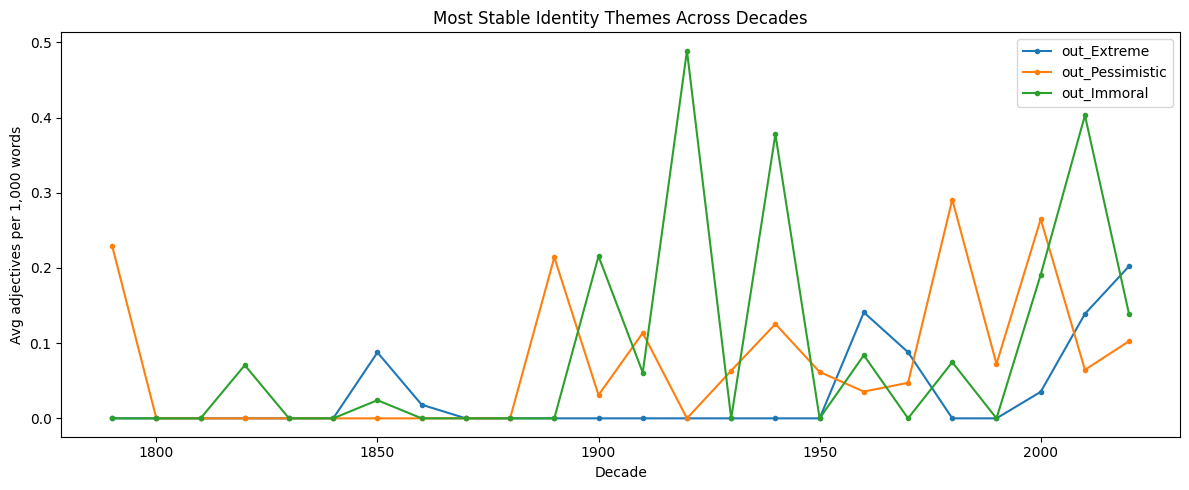

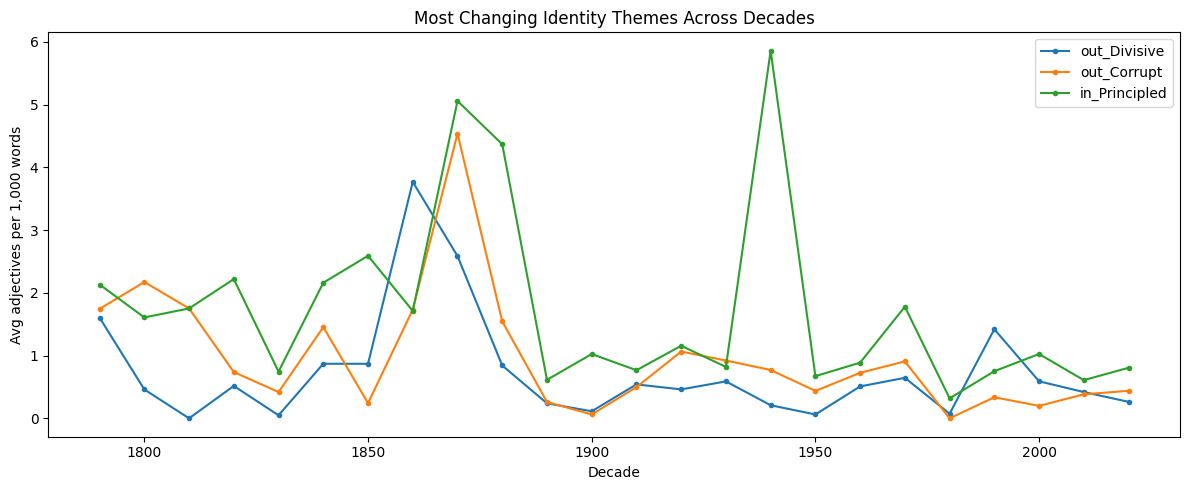

In [89]:
# pick 3 most stable and 3 most variable
stable_themes   = theme_variability.head(3).index.tolist()
variable_themes = theme_variability.tail(3).index.tolist()

# Clean labels (drop _per_1k)
def clean_label(col):
    return col.replace("_per_1k", "")

plt.figure(figsize=(12, 5))
for col in stable_themes:
    plt.plot(decade_means.index, decade_means[col], marker=".", label=clean_label(col))
plt.title("Most Stable Identity Themes Across Decades")
plt.xlabel("Decade")
plt.ylabel("Avg adjectives per 1,000 words")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for col in variable_themes:
    plt.plot(decade_means.index, decade_means[col], marker=".", label=clean_label(col))
plt.title("Most Changing Identity Themes Across Decades")
plt.xlabel("Decade")
plt.ylabel("Avg adjectives per 1,000 words")
plt.legend()
plt.tight_layout()
plt.show()


#### Looking at our measures

**Comparing regex counts and VADER sentiment**
- Regex: how often do presidents say "we/Americans" vs "they/others"?
- VADER: when they do, how positive/negative is the tone?

**Comparing volume measures vs adjective themes**
- Regex/VADER: broad we/they framing across full corpus
- Adjective themes: more direct content of identity words in LLM sample

**Summary tables / combined plots**
- Small table summarizing:
  - long-run trends in inclusion vs exclusion
  - sentiment gap between we and they
  - peaks in in-group/out-group themes by decade
